In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
TEST_DIR = Path('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/testset')
TRAIN_DIR = Path('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/train')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [4]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [5]:
val_files[0]

WindowsPath('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/train/simpsons_dataset/comic_book_guy/pic_0320.jpg')

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [7]:
class SimpsonsDataset2(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_a = transforms.Compose([
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform = transforms.Compose([
            #transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])


        if self.mode =='test':
            x = self._prepare_sample(x)
            x = transform(x)
            return x
        elif self.mode == 'val':
            x = self._prepare_sample(x)
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            x = transform_a(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [8]:
val_dataset2 = SimpsonsDataset2(val_files, mode='val')
    
train_dataset2 = SimpsonsDataset2(train_files, mode='train')

In [10]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import numpy as np
from tqdm import tqdm, trange

### Модель

In [12]:
model_VGG16 = models.vgg16(pretrained=True)
model_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# замораживаем
for param in model_extVGG.parameters():
    param.requires_grad = False

num_features = 4096

model_VGG16.classifier[6] = nn.Linear(num_features, 42)

model_VGG16 = model_VGG16.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_VGG16.classifier.parameters(), lr=0.001, momentum=0.9)

# эвристика
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
layers_to_unfreeze = 3

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_VGG16.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 4096

model_VGG16.classifier[6] = nn.Linear(num_features, 42)

model_VGG16 = model_VGG16.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и классифаер
optimizer = optim.SGD(list(model_VGG16.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_VGG16.classifier.parameters()), lr=0.001, momentum=0.9)


In [26]:
model_VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
def trainA(train_files, val_files, model, epochs, batch_size, optimizer, criterion):
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
                
        # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    print('Best val Acc: {:4f}'.format(best_acc))
            
    return history, model

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

обучаем

In [27]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [28]:
%%time
epochs = 30
batch_size=64

historyVGG, model_VGG16 = trainA(train_dataset2, val_dataset2, model_VGG16, epochs, batch_size, optimizer_ft, loss_fn )

torch.save(model_VGG16.state_dict(), 'model_VGG16.pth')

epoch:   0%|                                                                               | 0/30 [00:00<?, ?it/s]

loss 3.1357123628225483


epoch:   3%|██▎                                                                 | 1/30 [03:42<1:47:18, 222.03s/it]


Epoch 001 train_loss: 3.1357     val_loss 2.6989 train_acc 0.1441 val_acc 0.3080
loss 2.3882678208878727


epoch:   7%|████▌                                                               | 2/30 [07:17<1:41:42, 217.93s/it]


Epoch 002 train_loss: 2.3883     val_loss 2.1733 train_acc 0.3873 val_acc 0.4415
loss 1.9551888712424899


epoch:  10%|██████▊                                                             | 3/30 [10:50<1:37:10, 215.95s/it]


Epoch 003 train_loss: 1.9552     val_loss 1.8527 train_acc 0.5040 val_acc 0.5241
loss 1.673825740814209


epoch:  13%|█████████                                                           | 4/30 [14:20<1:32:35, 213.66s/it]


Epoch 004 train_loss: 1.6738     val_loss 1.6588 train_acc 0.5732 val_acc 0.5720
loss 1.4798879945754275


epoch:  17%|███████████▎                                                        | 5/30 [17:55<1:29:09, 213.99s/it]


Epoch 005 train_loss: 1.4799     val_loss 1.5438 train_acc 0.6201 val_acc 0.5904
loss 1.3319977815610313


epoch:  20%|█████████████▌                                                      | 6/30 [21:24<1:24:59, 212.49s/it]


Epoch 006 train_loss: 1.3320     val_loss 1.4282 train_acc 0.6558 val_acc 0.6167
loss 1.2104730139538638


epoch:  23%|███████████████▊                                                    | 7/30 [24:57<1:21:29, 212.60s/it]


Epoch 007 train_loss: 1.2105     val_loss 1.3514 train_acc 0.6832 val_acc 0.6402
loss 1.1156516147195947


epoch:  27%|██████████████████▏                                                 | 8/30 [28:31<1:18:03, 212.89s/it]


Epoch 008 train_loss: 1.1157     val_loss 1.2929 train_acc 0.7115 val_acc 0.6544
loss 1.0175409151859456


epoch:  30%|████████████████████▍                                               | 9/30 [31:39<1:11:45, 205.03s/it]


Epoch 009 train_loss: 1.0175     val_loss 1.2293 train_acc 0.7379 val_acc 0.6760
loss 0.9411186333241467


epoch:  33%|██████████████████████▎                                            | 10/30 [34:39<1:05:46, 197.30s/it]


Epoch 010 train_loss: 0.9411     val_loss 1.1831 train_acc 0.7587 val_acc 0.6859
loss 0.8794482299663268


epoch:  37%|████████████████████████▌                                          | 11/30 [37:40<1:00:59, 192.59s/it]


Epoch 011 train_loss: 0.8794     val_loss 1.1485 train_acc 0.7779 val_acc 0.6920
loss 0.8085500666712323


epoch:  40%|███████████████████████████▌                                         | 12/30 [40:42<56:47, 189.31s/it]


Epoch 012 train_loss: 0.8086     val_loss 1.1364 train_acc 0.7957 val_acc 0.6977
loss 0.7588080170352153


epoch:  43%|█████████████████████████████▉                                       | 13/30 [43:43<52:54, 186.71s/it]


Epoch 013 train_loss: 0.7588     val_loss 1.1132 train_acc 0.8096 val_acc 0.7069
loss 0.7004461672148269


epoch:  47%|████████████████████████████████▏                                    | 14/30 [46:44<49:20, 185.02s/it]


Epoch 014 train_loss: 0.7004     val_loss 1.0734 train_acc 0.8279 val_acc 0.7123
loss 0.6610971280014191


epoch:  50%|██████████████████████████████████▌                                  | 15/30 [49:44<45:52, 183.53s/it]


Epoch 015 train_loss: 0.6611     val_loss 1.0504 train_acc 0.8321 val_acc 0.7153
loss 0.6137387897567511


epoch:  53%|████████████████████████████████████▊                                | 16/30 [52:47<42:44, 183.17s/it]


Epoch 016 train_loss: 0.6137     val_loss 1.0402 train_acc 0.8502 val_acc 0.7209
loss 0.5699852026149007


epoch:  57%|███████████████████████████████████████                              | 17/30 [56:05<40:42, 187.88s/it]


Epoch 017 train_loss: 0.5700     val_loss 1.0063 train_acc 0.8656 val_acc 0.7289
loss 0.5386957991380616


epoch:  60%|█████████████████████████████████████████▍                           | 18/30 [59:39<39:07, 195.59s/it]


Epoch 018 train_loss: 0.5387     val_loss 0.9917 train_acc 0.8720 val_acc 0.7358
loss 0.49942068364849684


epoch:  63%|██████████████████████████████████████████▍                        | 19/30 [1:03:13<36:52, 201.17s/it]


Epoch 019 train_loss: 0.4994     val_loss 0.9897 train_acc 0.8847 val_acc 0.7360
loss 0.4645767821249016


epoch:  67%|████████████████████████████████████████████▋                      | 20/30 [1:06:45<34:02, 204.27s/it]


Epoch 020 train_loss: 0.4646     val_loss 1.0064 train_acc 0.8927 val_acc 0.7279
loss 0.4390916839546668


epoch:  70%|██████████████████████████████████████████████▉                    | 21/30 [1:10:17<31:00, 206.71s/it]


Epoch 021 train_loss: 0.4391     val_loss 0.9516 train_acc 0.9022 val_acc 0.7488
loss 0.4068790185743095


epoch:  73%|█████████████████████████████████████████████████▏                 | 22/30 [1:13:48<27:43, 207.88s/it]


Epoch 022 train_loss: 0.4069     val_loss 0.9415 train_acc 0.9113 val_acc 0.7491
loss 0.3751669601389037


epoch:  77%|███████████████████████████████████████████████████▎               | 23/30 [1:17:19<24:21, 208.84s/it]


Epoch 023 train_loss: 0.3752     val_loss 0.9409 train_acc 0.9198 val_acc 0.7553
loss 0.35220948968983673


epoch:  80%|█████████████████████████████████████████████████████▌             | 24/30 [1:20:49<20:55, 209.27s/it]


Epoch 024 train_loss: 0.3522     val_loss 0.9353 train_acc 0.9256 val_acc 0.7558
loss 0.33008245068873193


epoch:  83%|███████████████████████████████████████████████████████▊           | 25/30 [1:24:20<17:29, 209.82s/it]


Epoch 025 train_loss: 0.3301     val_loss 0.9246 train_acc 0.9322 val_acc 0.7574
loss 0.3111680869187008


epoch:  87%|██████████████████████████████████████████████████████████         | 26/30 [1:27:50<13:59, 209.88s/it]


Epoch 026 train_loss: 0.3112     val_loss 0.9177 train_acc 0.9371 val_acc 0.7595
loss 0.28421913277108896


epoch:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [1:31:20<10:29, 209.96s/it]


Epoch 027 train_loss: 0.2842     val_loss 0.9131 train_acc 0.9460 val_acc 0.7648
loss 0.26934568327876807


epoch:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [1:34:51<07:00, 210.15s/it]


Epoch 028 train_loss: 0.2693     val_loss 0.9160 train_acc 0.9485 val_acc 0.7618
loss 0.24956635528460788


epoch:  97%|████████████████████████████████████████████████████████████████▊  | 29/30 [1:38:21<03:30, 210.23s/it]


Epoch 029 train_loss: 0.2496     val_loss 0.9082 train_acc 0.9535 val_acc 0.7639
loss 0.23363540148980314


epoch: 100%|███████████████████████████████████████████████████████████████████| 30/30 [1:41:51<00:00, 203.73s/it]



Epoch 030 train_loss: 0.2336     val_loss 0.9005 train_acc 0.9597 val_acc 0.7663
Best val Acc: 0.766335
Wall time: 1h 41min 53s


In [29]:
loss, acc, val_loss, val_acc = zip(*historyVGG)

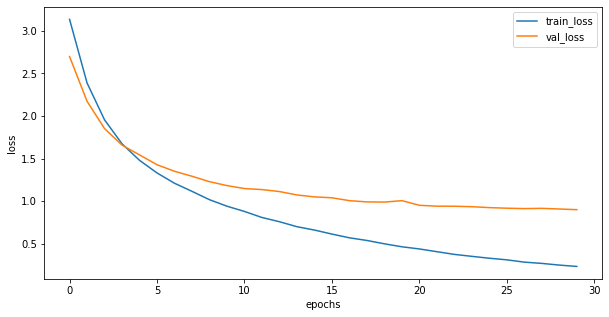

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()